In [7]:
# Last Name: Alawami
# Date: July 20, 2017
# Approach: First I wanted to assess the difficulty of the task so I loaded the data into R did some data exploration 
#           ran two basic models logistic regression and random forest (I can send those files of add them to this 
#           notebook, but I left them out for brevity). I got a passing AUC. So I fired up Python IDE to implement the 
#           models on it as is requested. For missing values in gender I created a new level variable "U" for unknown, 
#           though I can think of several appraoches would work just fine or perhaps even (slightly) better. I ran a 
#           random forest and varified the approperiate AUC. In building the model I ran Cross-Validation and did a 
#           some quick parameter tuning. I included an variable importance table, an ROC curve. Finally, I wanted to 
#           run another quick model so I ran XGboost. I got almost the same AUC value.
# Expected AUC = 0.851363764528964

In [2]:
### Set up data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Read in the data
data = pd.read_csv('data/train.csv')
X = data.iloc[:, :-1]
X.describe()
X.head()
X.info()

y = data.iloc[:, -1]

# Handle Missing Values
#from sklearn.preprocessing import Imputer
#
#imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
#X.loc[pd.isnull(X['gender']), 'gender'] = 'U'
X['gender'] = X['gender'].fillna('U')

# Encoding categorical data
# Easy way
X1 = pd.get_dummies(X, drop_first=True)
features_names = list(X1)

## Fancy way
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#
#X = X.values
#labelencoder = LabelEncoder()
#X[:, 2] = labelencoder.fit_transform(X2[:, 2])
#X[:, 3] = labelencoder.fit_transform(X2[:, 3])
#onehotencoder = OneHotEncoder(categorical_features = [2, 3])
#X = onehotencoder.fit_transform(X2).toarray()
#
## Drop extra dummy variable columns to avoid a singular matrix
#X = np.delete(X2, [0, 7], 1)

features_names = list(X1.columns)

# Split data into training and testing data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3, random_state=42, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 703.2+ KB


In [3]:
# Import necessary modules
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

### Fit Random Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 1000, random_state = 42)
cv_auc = cross_val_score(forest, X_train, y_train, cv=5, scoring='roc_auc')
forest.fit(X_train, y_train)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = forest.predict_proba(X_test)[:,1]

# Display Confusion Matrix, Classification Matrix, Variable Importance
print(confusion_matrix(y_test, forest.predict(X_test)))
print(classification_report(y_test, forest.predict(X_test)))

#print(dict(zip(features_names, forest.feature_importances_)))
print(pd.DataFrame(data={'features':features_names, 
                         'importance':forest.feature_importances_}).sort_values(['importance'], ascending = False))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = forest.predict_proba(X_test)[:,1]

# Print list of AUC scores for CV
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# Compute 5-fold cross-validation scores
print("Average 5-Fold CV Score: {}".format(np.mean(cv_auc)))
print("Approx. 95%% CI for Average 5-Fold CV Score:: %0.4f +/- %0.4f" % (np.mean(cv_auc), np.std(cv_auc) * 2))

# Compute and print AUC score for fitted model
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob))) # 0.8453497916601397


[[2695   10]
 [ 246   49]]
             precision    recall  f1-score   support

          0       0.92      1.00      0.95      2705
          1       0.83      0.17      0.28       295

avg / total       0.91      0.91      0.89      3000

                      features  importance
1                   cost_of_ad    0.193846
3                       income    0.179513
0                          age    0.141189
5                   n_vehicles    0.112195
6             prior_ins_tenure    0.098615
2   in_initial_launch_location    0.056679
11                    gender_M    0.053214
4                    n_drivers    0.049786
9           device_type_laptop    0.035883
7          device_type_desktop    0.034633
10           device_type_other    0.028050
8           device_type_iPhone    0.013390
12                    gender_U    0.003007
AUC scores computed using 5-fold cross-validation: [ 0.81662019  0.83069985  0.83048124  0.8576758   0.84008121]
Average 5-Fold CV Score: 0.835111659173897


Tuned Decision Tree Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 12, 'n_estimators': 3000}
Best score is 0.8456464988687518
AUC: 0.8514615119521288


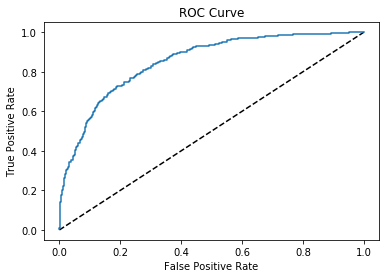

In [4]:
# Fine tune the model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 8, 10, None],
              "max_features": randint(1, X1.shape[1]),
              "min_samples_leaf": randint(1, X1.shape[1]),
              "criterion": ["gini", "entropy"],
              "class_weight": [None, "balanced"],
              "n_estimators": [1000, 2000, 3000]}

# Instantiate a Decision Tree classifier: tree
defaultforest = RandomForestClassifier()

# Tune the hyperparameter with RandomizedSearchCV: tree_cv
forest_cv = RandomizedSearchCV(defaultforest, param_dist, cv=5, scoring='roc_auc', random_state = 42, n_jobs=-1).fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_)) # 0.8454894547254883

# Compute predicted probabilities: y_pred_prob
y_pred_prob = forest_cv.predict_proba(X_test)[:,1]

# Compute and print AUC score for fitted model
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob))) # 0.851363764528964

# Generate ROC curve values: fpr, tpr, thresholds
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [5]:
### XGboost
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, metric=['auc'], scoring='roc_auc', seed=42)
xgb.fit(X_train, y_train)
xgboost_cv = RandomizedSearchCV(XGBClassifier(), 
                                {"max_depth": [3, 8, 10],
                                 "learning_rate": [0.01, 0.05, 0.10],
                                 "n_estimators": [1000, 2000, 3000]}, 
                                 cv=5, scoring='roc_auc', random_state = 42, n_jobs=-1).fit(X_train, y_train)

print("Tuned Decision Tree Parameters: {}".format(xgboost_cv.best_params_))
print("Best score is {}".format(xgboost_cv.best_score_)) # 0.8405380144287685

# Compute predicted probabilities: y_pred_prob
y_pred_prob = xgboost_cv.predict_proba(X_test)[:,1]

# Compute and print AUC score for fitted model
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob))) # 0.8483881073968482

Tuned Decision Tree Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}
Best score is 0.8405380144287685
AUC: 0.8483881073968482


In [6]:
# Compute Predictions
test = pd.read_csv('data/test.csv')
test['gender'] = test['gender'].fillna('U')
test = pd.get_dummies(test, drop_first=True)
forest_cv.predict_proba(test)[:5, 1]

array([ 0.13096203,  0.57217903,  0.22497381,  0.07966759,  0.06051087])